# dict源码解析

dict对象是一种关联式容器对象，用于保存由键到值的映射关系

## 基本用法

In [1]:
# 创建一个空dict对象
scores = {}
scores

{}

In [2]:
# 存储数据
scores['jim'] = 70
scores['lily'] = 75
scores['lucy'] = 80
scores['tom'] = 90
scores['alice'] = 95
scores

{'jim': 70, 'lily': 75, 'lucy': 80, 'tom': 90, 'alice': 95}

In [3]:
# 检索值
scores['jim']

70

In [4]:
# 剔除元素
scores.pop('lily')

75

## 内部结构

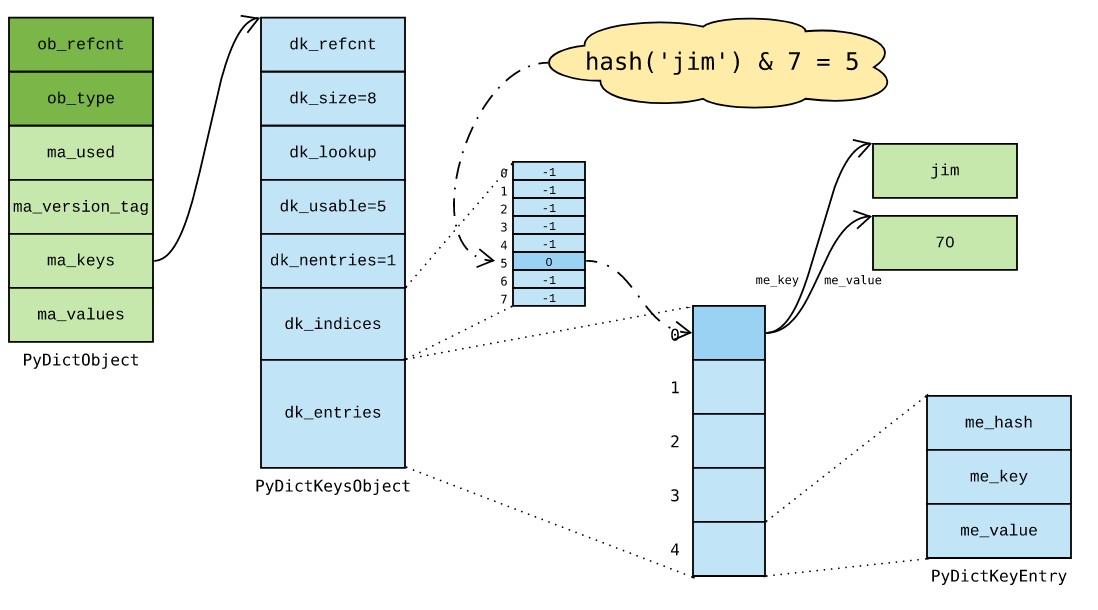

python中dict对象是基于散列表实现的

dict 对象真正的实现藏身于 PyDictKeysObject 中，它内部包含两个关键数组，一个是 键值对数组 `dk_entries` ，另一个是 哈希索引数组 `dk_indices` 。`dict` 所维护的键值对，按照先来后到的顺序保存于键值对数组中；而哈希索引数组对应槽位则保存着键值对在数组中的位置。
```python
typedef struct {
    PyObject_HEAD

    # 对象当前所保存的 键值对个数
    Py_ssize_t ma_used;

    # 对象当前版本号，每次修改时更新
    uint64_t ma_version_tag;
    # 指向按键对象映射的哈希表结构
    PyDictKeysObject *ma_keys;

    /* If ma_values is NULL, the table is "combined": keys and values
       are stored in ma_keys.
       If ma_values is not NULL, the table is splitted:keys are stored in ma_keys and values are stored in ma_values 
       */
    # 分离模式下指向由所有 值对象 组成的数组。
    PyObject **ma_values;
} PyDictObject;
```

```python
struct _dictkeysobject {
    # 引用计数，跟 映射视图 的实现有关，有点类似对象引用计数
    Py_ssize_t dk_refcnt;

    # 哈希表大小，必须是 2^n，这样可将模运算优化成 按位与 运算
    Py_ssize_t dk_size;

    # 哈希查找函数 指针，可根据 dict 当前状态选用最优函数版本
    dict_lookup_func dk_lookup;

    # 键值对数组 可用个数 
    Py_ssize_t dk_usable;

    # 键值对数组 已用个数
    Py_ssize_t dk_nentries;

    # 哈希表 起始地址 ，哈希表后紧接着 键值对数组 dk_entries
    char dk_indices[];  
```

```python
typedef struct {
    /* Cached hash code of me_key.
    */
    Py_hash_t me_hash;# 键对象的 哈希值 ，避免重复调用 __hash__ 计算哈希值；
    PyObject *me_key;# 键对象指针
    PyObject *me_value; # 值对象指针
} PyDictKeyEntry;
```

如上图，当我们往空 dict 对象插入新键值对 (‘jim’, 70) 时， Python 执行以下步骤：
1. 将键值对保存于 dk_entries 数组末尾，即下标为 0 的位置；
2. 计算键对象 ‘jim’ 的哈希值并取右 3 位，得到该键在哈希索引数组中的下标 5 ；
3. 将键值对在数组中的下标 0 ，保存于哈希索引数组中编号为 5 的槽位中。

这样一来，查找操作便可快速进行，分为以下几个步骤：
1. 计算键对象 ‘jim’ 的哈希值并取右 3 位，得到该键在哈希索引数组中的下标 5 ；
2. 找到哈希索引数组下标为 5 的槽位，取出其中保存的下标 0 ；
3. 找到键值对数组第 0 个位置，并取出 值对象 ；

由于 哈希值计算 以及 数组定位 均可在常数时间内完成，以上操作均可在常数时间内完成

## 容量策略

dict对象也有预分配机制
```python
#define PyDict_MINSIZE 8
#define USABLE_FRACTION(n) (((n) << 1)/3)
```
由 Objects/dictobject.c 源文件中的 PyDict_MINSIZE 宏定义，我们知道 dict 内部哈希表最小长度为 8

Python 通过 USABLE_FRACTION 宏将哈希表内元素控制在 2/3 以内

哈希表规模一定是 2^n ，也就是说 Python 采用 翻倍扩容 策略

## dict 哈希表

### 哈希值

*可哈希*(hashable)对象

只有可哈希对象才可作为哈希表的键
- 诸如list、dict等可变对象不是可哈希对象
- Python内建对象中的不可变对象(immutable)都是可哈希对象
- 用户自定义的对象默认是可哈希对象

### 哈希冲突

解决哈希冲突的常用方法：
- 分离链接法
- 开放寻址法（线性探测、平方探测）

### 哈希攻击

为了应对一些别有用心的人构造出大量哈希值相同的key提交给服务器，导致哈希表频繁发生哈希冲突，使用加盐方法：
1. Python 解释器进程启动后，产生一个随机数作为 盐 ；
2. 哈希函数同时参考 对象本身 以及 随机数 计算哈希值；

### 删除操作

哈希槽位状态常量在 Objects/dict-common.h 头文件中定义：
```python
#define DKIX_EMPTY (-1)
#define DKIX_DUMMY (-2)  /* Used internally */
#define DKIX_ERROR (-3)
```

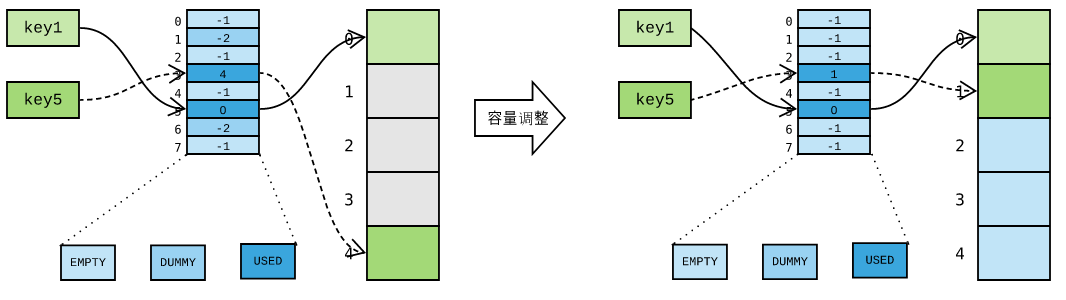

key1 最先插入，使用了哈希槽位 5 以及存储单元 0 ；紧接着插入 key2 ，使用了哈希槽位 1 以及存储单元 1 ；最后插入 key3 时，由于哈希槽位被 key2 占用，改用槽位 6 。

如果需要删除 key2 ，该如何操作呢？假设我们在将哈希槽位设置为 EMPTY ，并将存储单元标记为删除：

这样一来，由于 key3 哈希到的槽位 1 是空的，便误以为 key3 不存在。因此，删除元素时，必须将对应的哈希槽设置为一个特殊的标识 DUMMY ，避免中断哈希探测链：

那么，被删除的存储单元如何复用呢？Python 压根就没想费这个劲，直接使用新的不就好了吗？假设现在新插入 key4 ，Python 并不理会已删除存储单元 1 ，直接使用新的存储单元 3 ：

新哈希表规模由当前 dict 当前元素个数决定，因此容量调整有可能是 扩容 、缩容 或者 保持不变 。无论怎样，新哈希表创建后，便有新存储单元可用了！